In [1]:
print ("hello world")

hello world


In [2]:
# %load ../train_and_append_boosted.py
import statistics
import collections
import getopt, sys
import matplotlib.pyplot as plt
import numpy as np
from numpy import linspace
import pandas
import math
from sklearn.preprocessing import StandardScaler
import root_numpy
from ROOT import gSystem
from root_numpy import root2array, array2tree
import time
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import plot_model
from math import sqrt
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import ROOT
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import shap

Welcome to JupyROOT 6.14/04


Using TensorFlow backend.


ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

In [3]:
help(shap)

Help on package shap:

NAME
    shap - # flake8: noqa

PACKAGE CONTENTS
    _cext
    benchmark (package)
    common
    datasets
    explainers (package)
    plots (package)

SUBMODULES
    other

FUNCTIONS
    unsupported(*args, **kwargs)
        # plotting (only loaded if matplotlib is present)

DATA
    have_matplotlib = True

VERSION
    0.32.1

FILE
    /home/paredes/.local/lib/python3.6/site-packages/shap/__init__.py




In [4]:
class MyDict(collections.OrderedDict):
    def __missing__(self, key):
        val = self[key] = MyDict()
        return val


In [5]:
# This converts a flat ntuple into a numpy array file, which is the input
# format used by keras in our setup. Creates one .npz file per analysis in the
# directory where you run it.

# Location of the lists of ntuples you want to convert to numpy format.
# I've assumed that the file lists are named following my convention.
# e.g. "signalFiles_resolved.txt"
appendListLocation = "../datasets_to_train/"
appendListLocation = "../datasets_to_append/new_split_ntuples"

# Name of the tree we want to use
inTreeName = "preselection"

# Prefix for the name of the output .npz files
outputPrefix = "trainingData_all_jets_"
#outputPrefix = "validationData_"

#for analysis in ["resolved", "intermediate", "boosted"]:
for analysis in ["intermediate"]:
    #inFile_sig   = appendListLocation + "/signalFiles_" + analysis + "_SlfCoup_m1.0.txt"
    inFile_4b    = appendListLocation + "/4bFiles_" + analysis + ".txt"
    inFile_2b2j  = appendListLocation + "/2b2jFiles_" + analysis + ".txt"
    inFile_ttbar = appendListLocation + "/ttbarFiles_" + analysis + ".txt"
    inFile_sig       = appendListLocation + "/signalFiles_" + analysis + "_SlfCoup_5.0.txt"

    branchList = ["pT_hh","m_hh",
                  "nMuon", "nElec",
                  "h1_M", "h1_Pt", "h1_Eta", "h1_Phi", "h1_j1_j2_dR",
                  "h2_M", "h2_Pt", "h2_Eta", "h2_Phi", "h2_j1_j2_dR",
                  "met_Et", "met_Phi",
                  "h1_j1_BTag","h1_j2_BTag","h2_j1_BTag","h2_j2_BTag"
                 ]

    nFeatures = len(branchList)-1

    filepaths_sig   = []
    
    filepaths_4b    = []
    filepaths_2b2j  = []
    filepaths_ttbar = []

    f = open(inFile_sig,"r")
    for line in f:
        filepaths_sig.append(line.rstrip())
    f.close()

    f = open(inFile_4b,"r")
    for line in f:
        filepaths_4b.append(line.rstrip())
    f.close()

    f = open(inFile_2b2j,"r")
    for line in f:
        filepaths_2b2j.append(line.rstrip())
    f.close()

    f = open(inFile_ttbar,"r")
    for line in f:
        filepaths_ttbar.append(line.rstrip())
    f.close()

    dat_sig   = root2array(filepaths_sig,   branches=branchList, treename=inTreeName)

    dat_4b    = root2array(filepaths_4b,    branches=branchList, treename=inTreeName)
    dat_2b2j  = root2array(filepaths_2b2j,  branches=branchList, treename=inTreeName)
    dat_ttbar = root2array(filepaths_ttbar, branches=branchList, treename=inTreeName)

    #np.savez(outputPrefix + analysis + ".npz", sig=dat_sig, bkg_4b=dat_4b, bkg_2b2j=dat_2b2j, bkg_ttbar=dat_ttbar)


In [6]:
    nFeatures = len(branchList)-1


In [7]:
# This program trains a neural network based on input numpy array files.
# Output is one trained NN file (nn_*.h5) and one scaler file (scaler_*.sav)
# per analysis. Optionally also makes plots of the output distributions for the
# training sample.

### NOTE this program uses 0.2 of the data as a validation set

In [8]:
# Path of the directory whit lits of ntuples to append score to
fileListLocation = "test_append.txt"
# Path of the directory containing .npz files to train on.
# Standard naming convention is assumed (e.g. "trainingData_resolved.npz")
trainingDataPath = "../train_all_jets/"

In [9]:
# Training parameters
numEpochs = 10
batchSize = 100
dropoutFraction = 0.1
nNodes = 150
# initial learning rate for adamax
init_lr = MyDict()
init_lr["boosted"] = 5e-5
init_lr["intermediate"] = 5e-3
init_lr["resolved"] = 1e-1

# store parameters of the network in a string
#param_string = "_w_OPadamaxEP"+str(numEpochs)+"BS"+str(batchSize)+"DO"+str(dropoutFraction).replace(".","")
# Plot score distributions for the training sample?
makePlots = False

target_nevents = 100000

 
ttbar_weight = MyDict()
signal_weight = MyDict()
qcd_weight = MyDict()
analysis = "intermediate"
param_string = "testSave_all_jets_LR"+str(init_lr[analysis]).replace("0.","0p")
print ("paramters string "+param_string)

paramters string testSave_all_jets_LR0p005


In [10]:
# Load the input file and grab the data from it.
# Label each type of background
# Calculate weight for each 'target' sample
#inFile = np.load(trainingDataPath + "/trainingData_all_jets_" + analysis + ".npz")

signalData = pandas.DataFrame(dat_sig)
signalData["target"] = 0
print(len(signalData)," signal events")

10533  signal events


In [11]:
backgroundData = pandas.DataFrame(dat_4b)
backgroundData["target"] = 1
print(len(backgroundData)," 4b background")

350422  4b background


In [12]:
background_2b2j = pandas.DataFrame(dat_2b2j)
background_2b2j["target"] = 1
print(len(background_2b2j),"2b2j events")

347570 2b2j events


In [13]:
# take 4b to be  15% of the background
backgroundData = shuffle(backgroundData)
backgroundData = backgroundData[0:1580]

In [14]:
# and 2b2j 80%
background_2b2j = shuffle(background_2b2j)
background_2b2j = background_2b2j[0:8426]
backgroundData = backgroundData.append(background_2b2j)
print(len(backgroundData)," 2b2j background")


n_qcd_bkg = len(backgroundData)
qcd_weight[analysis] = target_nevents/n_qcd_bkg
print(n_qcd_bkg,"(",qcd_weight[analysis], ") qcd (weight) background events found")

10006  2b2j background
10006 ( 9.994003597841296 ) qcd (weight) background events found


In [15]:
background_ttbar = pandas.DataFrame(dat_ttbar)
#background_ttbar = pandas.DataFrame(inFile["bkg_ttbar"])
background_ttbar["target"] = 2
print(len(background_ttbar),"ttbar events")

39224 ttbar events


In [16]:
# and ttbar to 5%
background_ttbar = shuffle(background_ttbar)
background_ttbar = background_ttbar[0:527]
ttbar_weight[analysis] = target_nevents/len(background_ttbar)
print(len(background_ttbar),"(",ttbar_weight[analysis], ") ttbar (weight) background events found")
backgroundData = backgroundData.append(background_ttbar)
n_ttbar = len(background_ttbar)

527 ( 189.75332068311195 ) ttbar (weight) background events found


In [17]:
signal_weight[analysis] = target_nevents/len(signalData)
signalData = shuffle(signalData)

print(len(signalData),"(",signal_weight[analysis],") signal (weight) events found")

10533 ( 9.49397132820659 ) signal (weight) events found


In [18]:
print(len(backgroundData)," total background events")

10533  total background events


In [19]:
allData = signalData.append(backgroundData, ignore_index = True)

# Set all event weights to 1 by default
allData.loc[:, 'mc_sf'] = 1.
# Apply manual event weighting: numbers that give "reasonable behavior"
allData.loc[allData.target == 0,  'mc_sf'] = signal_weight[analysis]
allData.loc[allData.target == 1, 'mc_sf'] = qcd_weight[analysis]    # QCD
allData.loc[allData.target == 2, 'mc_sf'] = ttbar_weight[analysis]  # ttbar

allData = shuffle(allData)

In [20]:
balancedDataset = signalData.copy()

In [21]:
len(balancedDataset)

10533

In [22]:
len(backgroundData)

10533

In [23]:
len(background_ttbar)

527

In [24]:
xTrainData = allData
procType = xTrainData.pop("target")

#Here I'm only giving 'append' data, so none of these events were used in training
X_train, X_run, yTypeTrain, yTypeRun = train_test_split(xTrainData, procType, test_size=0.4, random_state=1)
X_train, X_test, yTypeTrain, yTypeTest = train_test_split(X_train, yTypeTrain, test_size=0.2, random_state=1)

# These aren't input features, separate them out.
evtWeightsTrain = X_train.pop("mc_sf")
evtWeightsVal = X_test.pop("mc_sf")
evtWeightsRun = X_run.pop("mc_sf")

In [25]:
X_train.head()

,pT_hh,m_hh,nMuon,nElec,h1_M,h1_Pt,h1_Eta,h1_Phi,h1_j1_j2_dR,h2_M,h2_Pt,h2_Eta,h2_Phi,h2_j1_j2_dR,met_Et,met_Phi,h1_j1_BTag,h1_j2_BTag,h2_j1_BTag,h2_j2_BTag
14007,100.015204,431.987332,0,0,60.497272,256.782471,1.167131,-2.388396,0.818812,73.095311,158.105785,0.891333,0.672238,0.884721,39.578560,0.788842,0,0,1,0
17700,452.283116,677.966997,0,0,119.163834,319.284760,0.267206,0.127935,0.804856,257.295738,186.843184,2.108043,-0.839424,2.653864,25.823748,-0.848849,0,1,0,0
7807,123.554621,569.072141,0,0,115.108444,299.741699,0.453540,2.211651,0.790881,101.618614,225.934654,-0.014831,-1.313041,0.873114,15.306190,1.850817,1,0,1,0
8800,322.947995,816.812646,0,0,139.357559,420.409821,-0.254420,-2.383287,0.673618,160.707180,186.942537,1.503529,1.576898,1.522830,115.202583,1.362615,1,1,0,1
2692,309.937452,565.722245,0,0,36.793182,461.659821,-0.388567,2.293291,1.122694,63.178485,166.885140,-0.657842,-0.501588,0.698483,47.100384,-0.784791,0,1,1,1


In [26]:
np.shape(X_train)

(10111, 20)

In [27]:
names = list(X_train.columns)

In [28]:
label_names = ['$p_T^{hh}$', '$m_{hh}$', '$N_\mu$', '$N_e$',
               '$m(h^{\mathrm{cand}}_1)$',
               '$p_T(h^{\mathrm{cand}}_1)$',
               '$\eta(h^{\mathrm{cand}}_1)$',
               '$\phi(h^{\mathrm{cand}}_1)$',
               '$\Delta R_{j_1,j_2}(h^{\mathrm{cand}}_1)$',
               '$m(h^{\mathrm{cand}}_2)$',
               '$p_T(h^{\mathrm{cand}}_2)$',
               '$\eta(h^{\mathrm{cand}}_2)$',
               '$\phi(h^{\mathrm{cand}}_2)$',
               '$\Delta R_{j_1,j_2}(h^{\mathrm{cand}}_2)$',
               '$E_T^{\mathrm{miss}}$',
               '$\phi(\mathrm{p}_T^{\mathrm{miss}})$',
               '$b$-tag$(h^{\mathrm{cand}}_1,j_1)$',
               '$b$-tag$(h^{\mathrm{cand}}_1,j_2)$',
               '$b$-tag$(h^{\mathrm{cand}}_2,j_1)$',
               '$b$-tag$(h^{\mathrm{cand}}_2,j_2)$']

In [29]:
names

['pT_hh',
 'm_hh',
 'nMuon',
 'nElec',
 'h1_M',
 'h1_Pt',
 'h1_Eta',
 'h1_Phi',
 'h1_j1_j2_dR',
 'h2_M',
 'h2_Pt',
 'h2_Eta',
 'h2_Phi',
 'h2_j1_j2_dR',
 'met_Et',
 'met_Phi',
 'h1_j1_BTag',
 'h1_j2_BTag',
 'h2_j1_BTag',
 'h2_j2_BTag']

In [30]:
# Convert pandas dataframes into numpy arrays
X_test = X_test.values
X_train = X_train.values
X_run = X_run.values
evtWeightsTrain = evtWeightsTrain.values
evtWeightsVal = evtWeightsVal.values
evtWeightsRun = evtWeightsRun.values
y_test = keras.utils.to_categorical(yTypeTest, num_classes=3)
y_train = keras.utils.to_categorical(yTypeTrain, num_classes=3)
yTypeTest = yTypeTest.values
yTypeTrain = yTypeTrain.values
yTypeRun = yTypeRun.values

In [31]:
print(np.unique(yTypeTrain,return_counts=True))
print(np.unique(yTypeTest,return_counts=True))
print(np.unique(yTypeRun,return_counts=True))

(array([0, 1, 2]), array([5065, 4809,  237]))
(array([0, 1, 2]), array([1255, 1201,   72]))
(array([0, 1, 2]), array([4213, 3996,  218]))


In [32]:
nnPath = "/home/paredes/pheno/testnn/pheno_study/analysis/neuralnet/train_alllambda_vs_bkg/nn_all_jets_"+analysis+"_allLambdas.h5"
scalerPath = "/home/paredes/pheno/testnn/pheno_study/analysis/neuralnet/train_alllambda_vs_bkg/scaler_"+analysis+"_allLambdas.sav"


In [33]:
# Convert this into the right format for keras
scaler = joblib.load(scalerPath)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [34]:
# load the trained NN
model = keras.models.load_model(nnPath)


2020-01-31 16:34:28.808629: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX


In [35]:
# select a set of background examples to take an expectation over
background = X_train[np.random.choice(X_train.shape[0], 10000, replace=False)]

In [36]:
e = shap.GradientExplainer(model, background)

In [37]:
import matplotlib as mpl
mymap = mpl.colors.ListedColormap(['green','red','blue'],name='mycolors')


In [38]:
shuffled_set = shuffle(X_train)
shap_set = shuffled_set[0:10000]

shap_values = e.shap_values(shap_set,ranked_outputs=None)

In [39]:
sig_shap = shap_values[0]

In [40]:
np.shape(sig_shap)

(10000, 20)

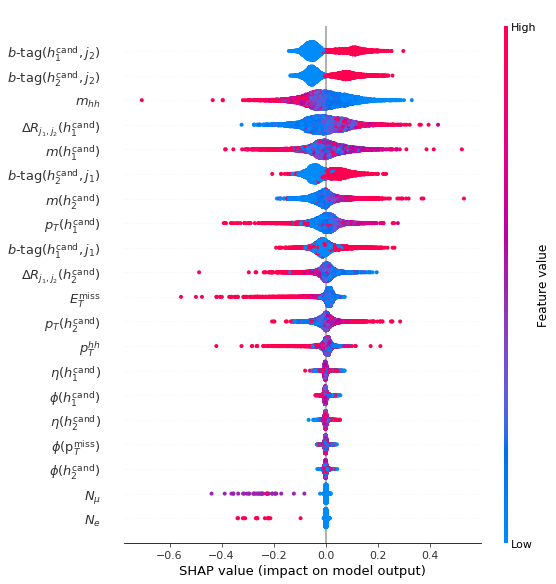

In [41]:
shap.summary_plot(sig_shap,shap_set,max_display=36,feature_names=label_names)

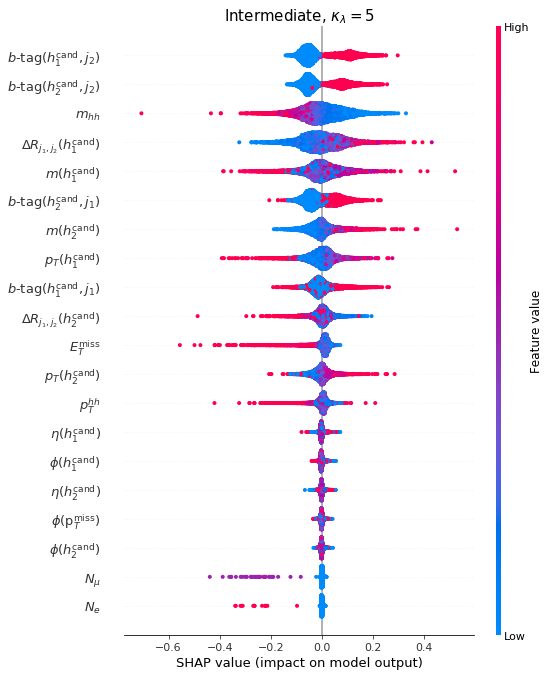

In [42]:
shap.summary_plot(sig_shap,shap_set,max_display=36,feature_names=label_names,show=False)
plt.title("Intermediate, $\kappa_{\lambda} = 5$",fontsize=15, horizontalalignment='center')
plt.tight_layout()
plt.savefig("/home/paredes/public_html/pheno/shap/shap_summary_intermediate_lambda5.pdf", dpi=500)

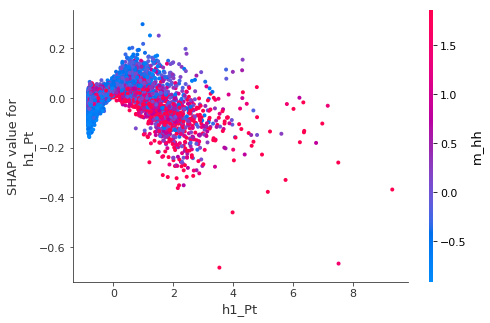

In [47]:
shap.dependence_plot('h1_Pt',sig_shap,shap_set,feature_names=names,interaction_index='m_hh')

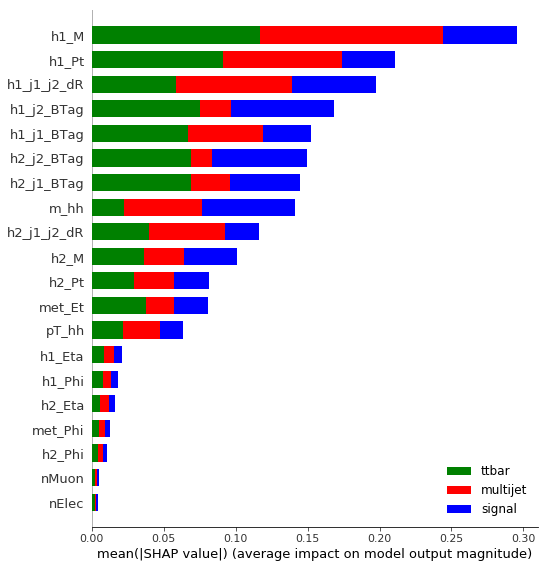

In [48]:
shap.summary_plot(shap_values, shap_set,max_display=36,feature_names=names,color=mymap,class_names=["signal","multijet","ttbar"])

In [50]:
help(shap.summary_plot)

Help on function summary_plot in module shap.plots.summary:

summary_plot(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, color_bar_label='Feature value', auto_size_plot=None)
    Create a SHAP summary plot, colored by feature values when they are provided.
    
    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.
    
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand
    
    feature_names : list
        Names of the features (length # features)
    
    max_display : int
        How many top features to incl

In [ ]:
shap.force_plot(e.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")

In [ ]:
# Run training sample back through the NN
probTrain = model.predict(X_train)
probTest = model.predict(X_test)

In [ ]:
import tensorflow as tf
tf.__version__


In [ ]:
history.history['val_acc'][-1]

In [ ]:
y_test

In [ ]:
probTest

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
thresholds = dict()
for i in range(0,3):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], probTest[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
plt.figure(figsize=(8,8))
lw = 2
colors = cycle(['firebrick', 'orange', 'deeppink','purple'])
styles = cycle(['--', ':','-.'])
signals = ["-20","-10","-2","-5","-0.5","0.5","10","20","2","5"]
plt.plot(fpr[1], tpr[1], color='blue',
         lw=lw, label='qcd score ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='green',
         lw=lw, label='ttbar score ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[0], tpr[0], color='red',
         lw=lw, label='sig.(SM) score ROC curve (area = %0.2f)' % roc_auc[0])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle=':')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves, individual scores')
plt.legend(loc="lower right")
plt.show()

In [28]:
signals[10]

IndexError: list index out of range

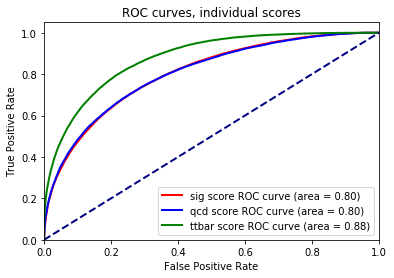

In [29]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='red',
         lw=lw, label='sig score ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='blue',
         lw=lw, label='qcd score ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='green',
         lw=lw, label='ttbar score ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves, individual scores')
plt.legend(loc="lower right")
plt.show()

In [30]:
thresholds[0][2000]

0.8393121

In [31]:
tpr[0][2000]

0.18492304470736048

In [32]:
fpr[0][2000]

0.013821833198887511

In [33]:
np.shape(tpr[0])

(44363,)

In [34]:
np.shape(fpr[0])

(44363,)

In [35]:
np.shape(thresholds[0])

(44363,)

In [36]:
np.shape(probTest)

(130812, 3)

In [37]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), probTest.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

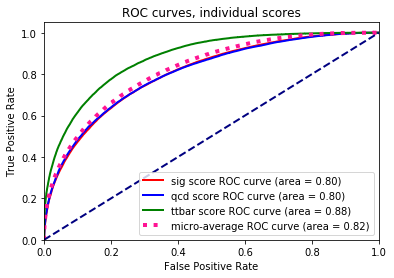

In [38]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='red',
         lw=lw, label='sig score ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='blue',
         lw=lw, label='qcd score ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='green',
         lw=lw, label='ttbar score ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves, individual scores')
plt.legend(loc="lower right")
plt.show()

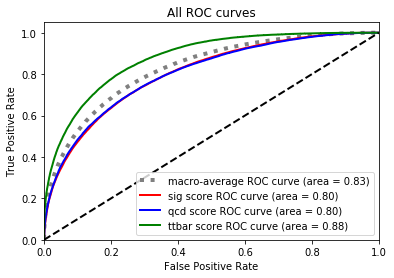

In [39]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(0,3)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(0,3):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 3

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
#plt.plot(fpr["micro"], tpr["micro"],
#         label='micro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["micro"]),
#         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='gray', linestyle=':', linewidth=4)

colors = cycle(['red', 'blue', 'green'])
types = cycle(['sig', 'qcd', 'ttbar'])
for i, color, typ in zip(range(0,3), colors, types):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0} score ROC curve (area = {1:0.2f})'.format(typ, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All ROC curves')
plt.legend(loc="lower right")
plt.show()


In [40]:
np.shape(probTest)


(130812, 3)

In [83]:
# Construct discriminant
scores_train = MyDict()
scores_test = MyDict()

# Format data for convenience
trainData = pandas.DataFrame(X_train)
testData = pandas.DataFrame(X_test)
scores_train = np.log(probTrain[:,0]/(1*probTrain[:,1]+1*probTrain[:,2]))
scores_test = np.log(probTest[:,0]/(1*probTest[:,1]+1*probTest[:,2]))
trainData['disc'] = pandas.Series(scores_train, index=trainData.index)
trainData['sig_score'] = pandas.Series(probTrain[:,0], index=trainData.index)
testData['disc'] = pandas.Series(scores_test, index=testData.index)
testData['sig_score'] = pandas.Series(probTest[:,0], index=testData.index)
trainData['qcd_score'] = pandas.Series(probTrain[:,1], index=trainData.index)
trainData['top_score'] = pandas.Series(probTrain[:,2], index=trainData.index)
trainData['weight'] = pandas.Series(evtWeightsTrain, index=trainData.index)
trainData['process'] = pandas.Series(yTypeTrain, index=trainData.index)


In [84]:
testData['qcd_score'] = pandas.Series(probTest[:,1], index=testData.index)
testData['top_score'] = pandas.Series(probTest[:,2], index=testData.index)
testData['weight'] = pandas.Series(evtWeightsVal, index=testData.index)
testData['process'] = pandas.Series(yTypeTest, index=testData.index)

Text(0.5,1,'intermediate (training and validation samples)')

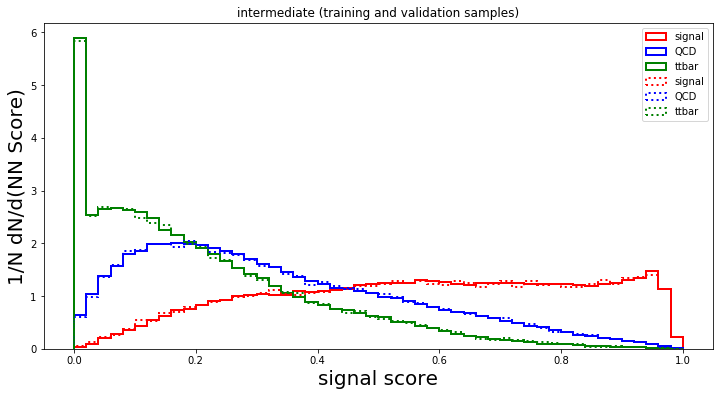

In [85]:
# Plot distributions of signal score on validation data
hist_params = {'density': True, 'bins': 50, 'linewidth': 2}
min_value = 0
max_value = 1
plt.figure(figsize=(12,6))
colors = cycle(['firebrick', 'orange', 'deeppink','gold'])
styles = cycle(['--', '-','-.'])

plt.hist(trainData[trainData.process == 0]['sig_score'], color=["r"], weights=trainData[trainData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='signal', **hist_params)
plt.hist(trainData[trainData.process == 1]['sig_score'], color=["b"], weights=trainData[trainData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(trainData[trainData.process == 2]['sig_score'], color=["g"], weights=trainData[trainData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.hist(testData[testData.process == 0]['sig_score'], color=["r"], linestyle = "dotted", weights=testData[testData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='signal', **hist_params)
plt.hist(testData[testData.process == 1]['sig_score'], color=["b"], linestyle = "dotted", weights=testData[testData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(testData[testData.process == 2]['sig_score'], color=["g"], linestyle = "dotted", weights=testData[testData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.legend(loc='best')
plt.xlabel("signal score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)
#plt.yscale('log')
plt.title(analysis + " (training and validation samples)")
#plt.figure(figsize=(12,6))
#plt.hist(trainData[trainData.process == 0]['qcd_score'], color=["r"], weights=trainData[trainData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
#plt.hist(trainData[trainData.process == 1]['qcd_score'], color=["b"], weights=trainData[trainData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
#plt.hist(trainData[trainData.process == 2]['qcd_score'], color=["g"], weights=trainData[trainData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
#plt.hist(testData[testData.process == 0]['qcd_score'], color=["r"], linestyle = "dotted", weights=testData[testData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal(Val)', **hist_params)
#plt.hist(testData[testData.process == 1]['qcd_score'], color=["b"], linestyle = "dotted", weights=testData[testData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD(Val)', **hist_params)
#plt.hist(testData[testData.process == 2]['qcd_score'], color=["g"], linestyle = "dotted", weights=testData[testData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar(Val)', **hist_params)
#plt.legend(loc='best')
#plt.xlabel("qcd score",fontsize=20)
#plt.ylabel("1/N dN/d(NN Score)",fontsize=20)
#plt.title(analysis + " (training and validation samples)")
#plt.figure(figsize=(12,6))
#plt.hist(trainData[trainData.process == 0]['top_score'], color=["r"], weights=trainData[trainData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
#plt.hist(trainData[trainData.process == 1]['top_score'], color=["b"], weights=trainData[trainData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
#plt.hist(trainData[trainData.process == 2]['top_score'], color=["g"], weights=trainData[trainData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
#plt.hist(testData[testData.process == 0]['top_score'], color=["r"], linestyle = "dotted", weights=testData[testData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal(Val)', **hist_params)
#plt.hist(testData[testData.process == 1]['top_score'], color=["b"], linestyle = "dotted", weights=testData[testData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD(Val)', **hist_params)
#plt.hist(testData[testData.process == 2]['top_score'], color=["g"], linestyle = "dotted", weights=testData[testData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar(Val)', **hist_params)
#plt.legend(loc='best')
#plt.xlabel("ttbar score",fontsize=20)
#plt.ylabel("1/N dN/d(NN Score)",fontsize=20)

Text(0,0.5,'1/N dN/d(NN Score)')

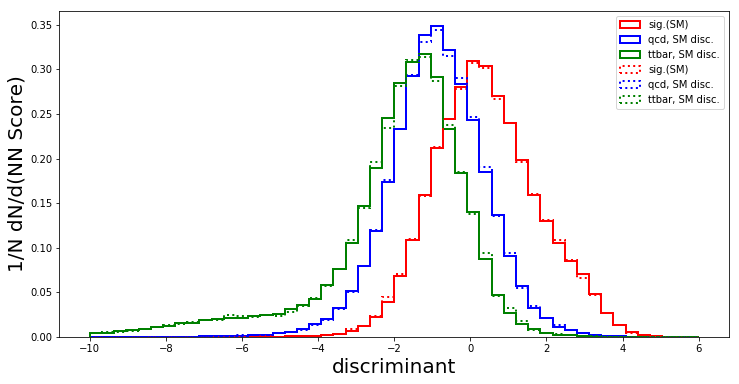

In [86]:
styles = cycle([':', '-.'])

plt.figure(figsize=(12,6))
plt.hist(trainData[trainData.process == 0]['disc'], linestyle = "-", color="red", weights=trainData[trainData.process == 0]['weight'], histtype='step', label="sig.(SM)", **hist_params,range=(-10, 6))
plt.hist(trainData[trainData.process == 1]['disc'], linestyle = "-", color="blue", weights=trainData[trainData.process == 1]['weight'], histtype='step', label="qcd, SM disc.", **hist_params,range=(-10,6))
plt.hist(trainData[trainData.process == 2]['disc'], linestyle = "-", color="green", weights=trainData[trainData.process == 2]['weight'], histtype='step', label="ttbar, SM disc.", **hist_params,range=(-10, 6))
plt.hist(testData[testData.process == 0]['disc'], linestyle = ":", color="red", weights=testData[testData.process == 0]['weight'], histtype='step', label="sig.(SM)", **hist_params,range=(-10, 6))
plt.hist(testData[testData.process == 1]['disc'], linestyle = ":", color="blue", weights=testData[testData.process == 1]['weight'], histtype='step', label="qcd, SM disc.", **hist_params,range=(-10,6))
plt.hist(testData[testData.process == 2]['disc'], linestyle = ":", color="green", weights=testData[testData.process == 2]['weight'], histtype='step', label="ttbar, SM disc.", **hist_params,range=(-10, 6))
plt.legend(loc='best')
plt.xlabel("discriminant",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)

In [70]:
plt.figure(figsize=(12,6))
plt.hist(trainData[trainData.process == 0]['disc_'+str(0)], linestyle = "-", color="red", weights=trainData[trainData.process == 0]['weight'], histtype='step', label="sig.(SM)", **hist_params,range=(-3, -1.5))
plt.hist(trainData[trainData.process == 1]['disc_'+str(0)], linestyle = "-", color="blue", weights=trainData[trainData.process == 1]['weight'], histtype='step', label="qcd, SM disc.", **hist_params,range=(-3.5, -1))
plt.hist(trainData[trainData.process == 2]['disc_'+str(0)], linestyle = "-", color="green", weights=trainData[trainData.process == 2]['weight'], histtype='step', label="ttbar, SM disc.", **hist_params,range=(-3.5, -1))
plt.legend(loc='best')
plt.xlabel("discriminant",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)

KeyError: 'disc_0'

<Figure size 864x432 with 0 Axes>

In [243]:
print(np.unique(yTypeRun,return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([ 30372, 153682, 124071,  11301,  14502,  14750,  14556,  15096,
        15566,  13396,   1416,  14559,  12773]))


In [244]:
##append_mc_sf = signalAppendData.pop("mc_sf")
#append_mc_sf = X_run.pop("mc_sf")
#append_mc_sf = append_mc_sf.values
## Convert pandas dataframes into numpy arrays
## signalAppendData = signalAppendData.values
#X_run = X_run.values

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.

In [69]:
X_run_clone = X_run
X_run_forload = X_run
appendData_clone = pandas.DataFrame(X_run_clone)

X_run = classStd1.transform(X_run)


In [70]:
# Run training sample back through the NN
probAppend = model.predict(X_run)

In [71]:
# Format data for convenience
appendData = pandas.DataFrame(X_run)
appendData['sig_score'] = pandas.Series(probAppend[:,0], index=appendData.index)
appendData['qcd_score'] = pandas.Series(probAppend[:,1], index=appendData.index)
appendData['top_score'] = pandas.Series(probAppend[:,2], index=appendData.index)
appendData['weight'] = pandas.Series(evtWeightsRun, index=appendData.index)
appendData['process'] = pandas.Series(yTypeRun, index=appendData.index)


print("signal score mean = ", statistics.mean(appendData['sig_score']))
print("   QCD score mean = ", statistics.mean(appendData['qcd_score']))
print(" ttbar score mean = ", statistics.mean(appendData['top_score']))

signal score mean =  0.048669679339775916
   QCD score mean =  0.058831766147861043
 ttbar score mean =  0.04495639049864028


In [72]:
probAppend[:,2]
len(appendData[appendData.process == 2])
print(np.unique(yTypeRun,return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([ 17027, 412063,  24234,   8231,  11008,  13238,  11868,  14838,
        17830,   8726,    978,  23462,   8532]))


In [49]:
# Plot distributions of signal score on validation data
hist_params = {'density': True, 'bins': 50, 'linewidth': 2}
min_value = 0
max_value = 1
plt.figure(figsize=(12,6))
plt.hist(appendData[appendData.process == 0]['sig_score'], color=["r"], weights=appendData[appendData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.hist(appendData[appendData.process == 1]['sig_score'], color=["b"], weights=appendData[appendData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(appendData[appendData.process == 2]['sig_score'], color=["g"], weights=appendData[appendData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.legend(loc='best')
plt.xlabel("signal score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)
#plt.yscale('log')
plt.title(analysis + " (training and validation samples)")
plt.figure(figsize=(12,6))
plt.hist(appendData[appendData.process == 0]['qcd_score'], color=["r"], weights=appendData[appendData.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.hist(appendData[appendData.process == 1]['qcd_score'], color=["b"], weights=appendData[appendData.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(appendData[appendData.process == 2]['qcd_score'], color=["g"], weights=appendData[appendData.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.legend(loc='best')
plt.xlabel("qcd score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)

NameError: name 'appendData' is not defined

<Figure size 864x432 with 0 Axes>

Text(0,0.5,'leading higgs candidate mass')

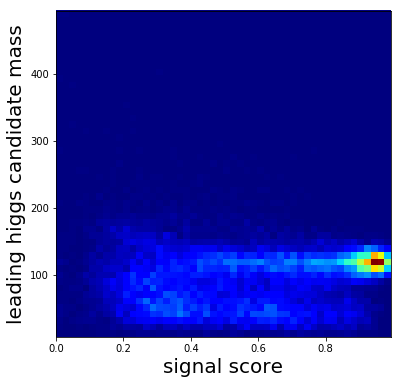

In [35]:
appendData_clone['process'] = pandas.Series(yTypeRun, index=appendData.index)
plt.figure(figsize=(6,6))
plt.hist2d(appendData[appendData.process == 0]['sig_score'],appendData_clone[appendData_clone.process == 0][3],bins=(50,50),cmap=plt.cm.jet)
plt.xlabel("signal score",fontsize=20)
plt.ylabel("leading higgs candidate mass",fontsize=20)

In [36]:
plt.savefig("nn_vs_h1M_signal.png")

<Figure size 432x288 with 0 Axes>

In [37]:
appendData_clone.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,process
0,186.631434,0.0,0.0,68.361534,253.323441,-0.524437,-2.601593,0.228536,73.704294,121.510046,1.568009,-0.232106,1.085954,40.007195,-1.604813,0.0,0.0,0.0,0.0,1
1,19.246565,0.0,0.0,32.864246,301.971924,0.637259,0.767390,0.789446,155.638248,285.364342,2.445060,-2.341065,1.406430,22.644180,-2.209389,1.0,0.0,1.0,1.0,1
2,309.985355,0.0,0.0,77.471573,569.283447,1.573768,2.441730,0.269151,171.550151,300.508743,0.760250,-0.324270,1.021325,95.283180,-0.824976,0.0,0.0,0.0,1.0,1
3,303.275969,0.0,0.0,116.438461,319.647095,-1.195304,2.025725,0.799697,128.058219,38.536932,0.516869,-2.192588,3.137063,15.753584,-1.177011,1.0,0.0,1.0,0.0,1
4,247.359568,0.0,0.0,93.953156,461.447540,1.474505,-1.597965,0.640714,153.017616,227.548474,1.075794,1.294602,1.200118,68.352905,1.596076,0.0,1.0,1.0,1.0,1


In [38]:
loaded_model = keras.models.load_model("./testingAppend.h5")
loaded_scaler = joblib.load("scaler_testingAppend.sav")
X_run_forload = classStd1.transform(X_run_forload)



Text(0,0.5,'1/N dN/d(NN Score)')

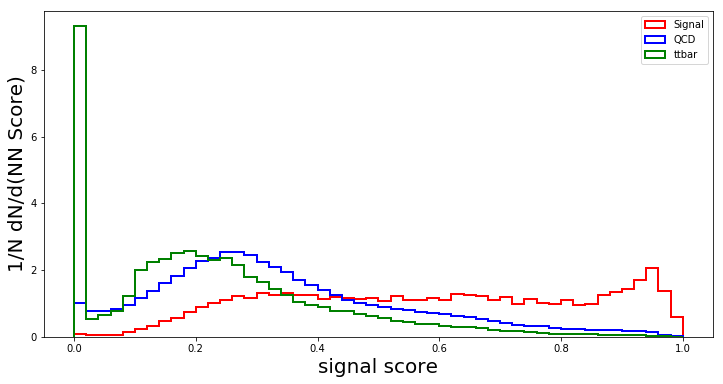

In [39]:
pred_loaded = loaded_model.predict(X_run_forload)

loaded_model_Data = pandas.DataFrame(X_run_forload)
loaded_model_Data['sig_score'] = pandas.Series(pred_loaded[:,0], index=loaded_model_Data.index)
loaded_model_Data['qcd_score'] = pandas.Series(pred_loaded[:,1], index=loaded_model_Data.index)
loaded_model_Data['top_score'] = pandas.Series(pred_loaded[:,2], index=loaded_model_Data.index)
loaded_model_Data['weight'] = pandas.Series(evtWeightsRun, index=loaded_model_Data.index)
loaded_model_Data['process'] = pandas.Series(yTypeRun, index=loaded_model_Data.index)

hist_params = {'density': True, 'bins': 50, 'linewidth': 2}
min_value = 0
max_value = 1
plt.figure(figsize=(12,6))
plt.hist(loaded_model_Data[loaded_model_Data.process == 0]['sig_score'], color=["r"], weights=loaded_model_Data[loaded_model_Data.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.hist(loaded_model_Data[loaded_model_Data.process == 1]['sig_score'], color=["b"], weights=loaded_model_Data[loaded_model_Data.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(loaded_model_Data[loaded_model_Data.process == 2]['sig_score'], color=["g"], weights=loaded_model_Data[loaded_model_Data.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.legend(loc='best')
plt.xlabel("signal score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)

In [40]:
pred_sig_only = model.predict(allXdata_scaled)

Text(0,0.5,'1/N dN/d(NN Score)')

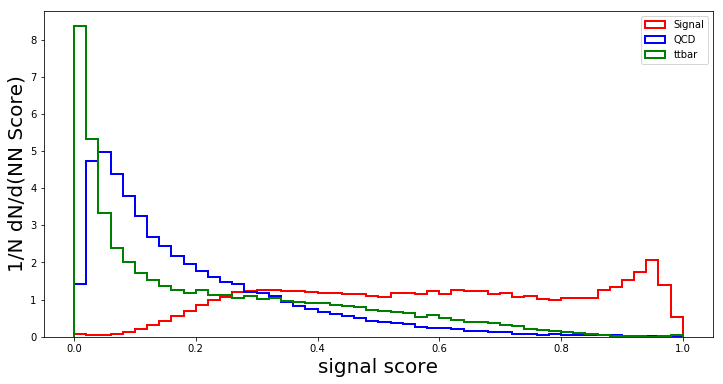

In [41]:
sig_only_Data = pandas.DataFrame(allXdata_scaled)
sig_only_Data['sig_score'] = pandas.Series(pred_sig_only[:,0], index=sig_only_Data.index)
sig_only_Data['qcd_score'] = pandas.Series(pred_sig_only[:,1], index=sig_only_Data.index)
sig_only_Data['top_score'] = pandas.Series(pred_sig_only[:,2], index=sig_only_Data.index)

hist_params = {'density': True, 'bins': 50, 'linewidth': 2}
min_value = 0
max_value = 1
plt.figure(figsize=(12,6))
plt.hist(sig_only_Data['sig_score'], color=["r"], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.hist(sig_only_Data['qcd_score'], color=["b"], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(sig_only_Data['top_score'], color=["g"], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.legend(loc='best')
plt.xlabel("signal score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)

/cvmfs/sft.cern.ch/lcg/views/LCG_94python3/x86_64-slc6-gcc8-opt/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0,0.5,'1/N dN/d(NN Score)')

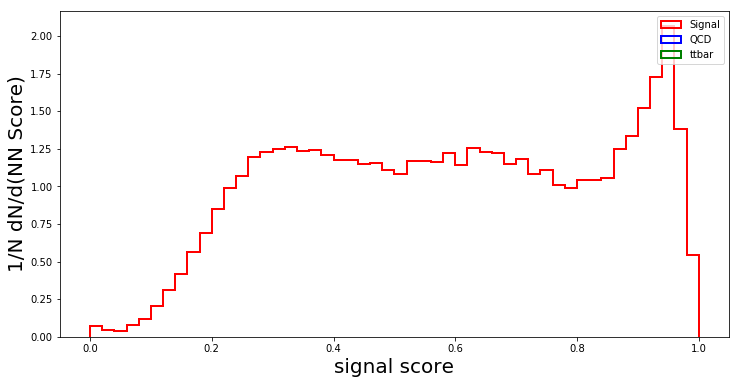

In [42]:
sig_only_Data['weight'] = pandas.Series(sig_only_mc_sf, index=sig_only_Data.index)
sig_only_Data['process'] = pandas.Series(sig_only_target, index=sig_only_Data.index)

hist_params = {'density': True, 'bins': 50, 'linewidth': 2}
min_value = 0
max_value = 1
plt.figure(figsize=(12,6))
plt.hist(sig_only_Data[sig_only_Data.process == 0]['sig_score'], color=["r"], weights=sig_only_Data[sig_only_Data.process == 0]['weight'], range=(min_value, max_value), histtype='step', label='Signal', **hist_params)
plt.hist(sig_only_Data[sig_only_Data.process == 1]['sig_score'], color=["b"], weights=sig_only_Data[sig_only_Data.process == 1]['weight'], range=(min_value, max_value), histtype='step', label='QCD', **hist_params)
plt.hist(sig_only_Data[sig_only_Data.process == 2]['sig_score'], color=["g"], weights=sig_only_Data[sig_only_Data.process == 2]['weight'], range=(min_value, max_value), histtype='step', label='ttbar', **hist_params)
plt.legend(loc='best')
plt.xlabel("signal score",fontsize=20)
plt.ylabel("1/N dN/d(NN Score)",fontsize=20)